## Training (Image_SSE)

In [ ]:
pip install torchnet

In [2]:
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, confusion_matrix

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/FML Project') 

## Set Device

In [4]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Features and Labels

In [5]:
labels = np.load(sys.path[-1]+"/Data/labels.npy")
print('Labels loaded!')

Labels loaded!


In [6]:
image_features = torch.load(sys.path[-1]+"/Data/image_features.pt")
print('Image features loaded!')

Image features loaded!


## Split Data

In [7]:
df = pd.read_csv(sys.path[-1]+"/Data/df_final.csv")
train_ids = list(df[df['target_date'] < '2015-08-01'].index)
valid_ids = list(df[df['target_date'].between('2015-08-01','2015-10-01')].index)
test_ids = list(df[df['target_date'] > '2015-10-01'].index)
print(len(train_ids), len(valid_ids), len(test_ids))

14040 1910 2593


In [8]:
dataset = TensorDataset([image_features.float(), torch.tensor(labels).float()])

train_set = TensorDataset([torch.utils.data.Subset(dataset, train_ids)])
valid_set = TensorDataset([torch.utils.data.Subset(dataset, valid_ids)])
test_set = TensorDataset([torch.utils.data.Subset(dataset, test_ids)])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print('Datasets ready!')

Datasets ready!


## Evaluation Metrics

In [9]:
def compute_accuracy(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return accuracy_score(np.array(y_true), np.array(y_pred))

def compute_f1(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return f1_score(np.array(y_true), np.array(y_pred))

def compute_MCC(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return matthews_corrcoef(np.array(y_true), np.array(y_pred))

def evaluate_metrics(preds, labels):
    labels = [int(item) for item in labels]
    preds = [0 if item < 0.5 else 1 for item in preds]
    accuracy = compute_accuracy(labels, preds)
    f1 = compute_f1(labels, preds)
    mcc = compute_MCC(labels, preds)
    cm = confusion_matrix(labels, preds)
    return accuracy, f1, mcc, cm

## Training

In [10]:
def save_model(model, name):
    torch.save(model.state_dict(), name)

def load_model(model, name):
    weights = torch.load(name)
    model.load_state_dict(weights)
    return model

In [11]:
def train_model(model, params, train_loader, valid_loader, test_loader, report_loss=True):

    device = params['device']
    n_epochs = params['n_epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    scheduler = params['scheduler']

    stop = 0
    best_valid_mcc = -1

    valid_metrics = {}
    test_metrics = {}
    train_loss, valid_loss, test_loss = [], [], []
    valid_a, valid_f1, valid_mcc, valid_cm = [], [], [], []
    test_a, test_f1, test_mcc, test_cm = [], [], [], []

    f = nn.Sigmoid()

    for epoch in range(n_epochs):

        train_loss_i, batch, total = 0.0, 0, 0
        model.train()
        for data in tqdm(train_loader):
            if params['model_type'] == 'unimodal':
                x, labels = data[0][0].to(device), data[0][1].to(device)
                preds = model(x)
            elif params['model_type'] == 'bimodal':
                x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                preds = model(x_txt, x_img)
            preds = f(preds).squeeze()
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_i += loss.item()
            batch += 1
            total += labels.shape[0]
            if report_loss and batch%200==0:
                print("Batch: {}, Training Loss: {:.4f}".format(batch, train_loss_i/total))
        train_loss_i = train_loss_i / len(train_loader.dataset)

        valid_loss_i = 0.0
        valid_preds, valid_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(valid_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                valid_loss_i += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
        valid_loss_i = valid_loss_i / len(valid_loader.dataset)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)

        valid_a_i, valid_f1_i, valid_mcc_i, valid_cm_i = evaluate_metrics(valid_preds, valid_labels)

        test_loss_i = 0.0
        test_preds, test_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                test_loss_i += loss.item()
                test_preds.append(preds)
                test_labels.append(labels)
        test_loss_i = test_loss_i / len(test_loader.dataset)
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)

        test_a_i, test_f1_i, test_mcc_i, test_cm_i = evaluate_metrics(test_preds, test_labels)

        scheduler.step(valid_loss_i)  # decay learning rate by validation loss

        if valid_mcc_i > best_valid_mcc:
            save_model(model, sys.path[-1]+'/Models/'+params['model_name']+'.pt')
            print("Saved model at epoch {} with validation MCC score of {:.4f}%".format(epoch+1, valid_mcc_i))
            best_valid_mcc = valid_mcc_i

        if report_loss:
            print("\n")
            print("-" * 50)
            print("Epoch ", epoch+1)
            print("Training Loss: {:.4f}, Validation Loss: {:.4f}".format(train_loss_i, valid_loss_i))
            print('Validation Results: ')
            print("Accuracy: {:.4f}".format(valid_a_i))
            print("F1 Score: {:.4f}".format(valid_f1_i))
            print("MCC Score: {:.4f}".format(valid_mcc_i))
            print('Test Results: ')
            print("Accuracy: {:.4f}".format(test_a_i))
            print("F1 Score: {:.4f}".format(test_f1_i))
            print("MCC Score: {:.4f}".format(test_mcc_i))
            print("-" * 50)
            print("\n")
        
        train_loss.append(train_loss_i)
        valid_loss.append(valid_loss_i)
        test_loss.append(test_loss_i)

        valid_a.append(valid_a_i)
        valid_f1.append(valid_f1_i)
        valid_mcc.append(valid_mcc_i)
        valid_cm.append(valid_cm_i)

        test_a.append(test_a_i)
        test_f1.append(test_f1_i)
        test_mcc.append(test_mcc_i)
        test_cm.append(test_cm_i)


        if len(valid_loss) > 0:  
            if valid_loss_i <= valid_loss[-1]:
                stop = 0
            else:
                stop += 1
                if stop >= int(params['n_stop']):   # stop training when no improvement observed in consecutive epoches
                    print("Early stopped. No improvement in validation loss for params['n_stop'] consecutive epoches.")
                    break

    valid_metrics['acc'] = valid_a
    valid_metrics['f1'] = valid_f1
    valid_metrics['mcc'] = valid_mcc
    valid_metrics['cm'] = valid_cm

    test_metrics['acc'] = test_a
    test_metrics['f1'] = test_f1
    test_metrics['mcc'] = test_mcc
    test_metrics['cm'] = test_cm

    return train_loss, valid_loss, test_loss, valid_metrics, test_metrics

## Models

In [12]:
class Image_SSE(nn.Module):
    """
    Unimodal (image) classifier based on self-supervised embeddings.
    """
    def __init__(self, params):
        super(Image_SSE, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=params['img_dropout'])
        # fully connected layers
        self.reduce_dim = nn.Linear(in_features=params['img_embed_size'],
                                    out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)

    def forward(self, x_img):
        """
        Input:
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
        """
        # dimension reduction
        x_img = self.relu(self.reduce_dim(x_img))
        # dropout
        x_img = self.dropout(x_img)
        # classification
        y = self.classifier(x_img)
        return y

## Unimodal

In [17]:
model_params = {'txt_embed_size': 768,
                'img_embed_size': 2048,
                'hidden_size': 128,
                'txt_H': 4,
                'vt_H': 4,
                'txt_dropout': 0.01,
                'img_dropout': 0.01,
                'vt_dropout': 0.01,
                'transformer_dropout': 0.01}  

best_acc, best_f1, best_mcc, best_cm = [], [], [], []

for i in range(5):

    model = Image_SSE(model_params)
    model.to(device)
    criterion = nn.BCELoss()    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
    train_params = {'n_epochs': 30,
                    'criterion': criterion,
                    'optimizer': optimizer,
                    'scheduler': scheduler,
                    'n_stop': 8,
                    'model_name': 'Image_SSE',
                    'model_type': 'unimodal',
                    'device': device}

    train_loss, valid_loss, test_loss, valid_metrics, test_metrics = train_model(model, train_params, train_loader, valid_loader, test_loader)
        
    idx = np.argmax(test_metrics['mcc'])
    best_acc.append(test_metrics['acc'][idx])
    best_f1.append(test_metrics['f1'][idx])
    best_mcc.append(test_metrics['mcc'][idx])
    best_cm.append(test_metrics['cm'][idx])

    with open(sys.path[-1]+f"/Training Results/train_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(train_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_loss, f)
    with open(sys.path[-1]+f"/Training Results/test_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_metrics, f)
    with open(sys.path[-1]+f"/Training Results/test_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_metrics, f)

 34%|███▍      | 300/878 [00:00<00:01, 575.27it/s]

Batch: 200, Training Loss: 0.0434


 54%|█████▍    | 477/878 [00:00<00:00, 565.56it/s]

Batch: 400, Training Loss: 0.0435


 81%|████████  | 708/878 [00:01<00:00, 565.02it/s]

Batch: 600, Training Loss: 0.0435


100%|██████████| 878/878 [00:01<00:00, 574.83it/s]


Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 465.16it/s]


Saved model at epoch 1 with validation MCC score of 0.0600%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.5913
MCC Score: 0.0600
Test Results: 
Accuracy: 0.5175
F1 Score: 0.6070
MCC Score: 0.0164
--------------------------------------------------




 34%|███▎      | 295/878 [00:00<00:01, 580.92it/s]

Batch: 200, Training Loss: 0.0434


 54%|█████▍    | 474/878 [00:00<00:00, 583.50it/s]

Batch: 400, Training Loss: 0.0433


 74%|███████▎  | 646/878 [00:01<00:00, 496.92it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 556.75it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 486.32it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4665
F1 Score: 0.6024
MCC Score: 0.0071
Test Results: 
Accuracy: 0.5218
F1 Score: 0.6447
MCC Score: 0.0152
--------------------------------------------------




 35%|███▍      | 303/878 [00:00<00:00, 582.94it/s]

Batch: 200, Training Loss: 0.0432


 55%|█████▍    | 482/878 [00:00<00:00, 585.15it/s]

Batch: 400, Training Loss: 0.0432


 75%|███████▍  | 657/878 [00:01<00:00, 572.10it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 580.55it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 457.96it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4906
F1 Score: 0.5882
MCC Score: 0.0406
Test Results: 
Accuracy: 0.5318
F1 Score: 0.6139
MCC Score: 0.0486
--------------------------------------------------




 33%|███▎      | 294/878 [00:00<00:01, 573.87it/s]

Batch: 200, Training Loss: 0.0432


 54%|█████▍    | 472/878 [00:00<00:00, 583.39it/s]

Batch: 400, Training Loss: 0.0433


 80%|████████  | 706/878 [00:01<00:00, 580.39it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 566.15it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 439.19it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5893
MCC Score: 0.0599
Test Results: 
Accuracy: 0.5276
F1 Score: 0.6034
MCC Score: 0.0410
--------------------------------------------------




 32%|███▏      | 278/878 [00:00<00:01, 533.45it/s]

Batch: 200, Training Loss: 0.0431


 56%|█████▌    | 492/878 [00:00<00:00, 525.99it/s]

Batch: 400, Training Loss: 0.0432


 80%|████████  | 706/878 [00:01<00:00, 525.03it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 522.22it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 477.56it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4576
F1 Score: 0.6114
MCC Score: -0.0073
Test Results: 
Accuracy: 0.5241
F1 Score: 0.6658
MCC Score: 0.0141
--------------------------------------------------




 30%|███       | 264/878 [00:00<00:01, 518.21it/s]

Batch: 200, Training Loss: 0.0433


 55%|█████▌    | 484/878 [00:00<00:00, 541.75it/s]

Batch: 400, Training Loss: 0.0433


 81%|████████  | 712/878 [00:01<00:00, 559.05it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 546.59it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 488.04it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5755
MCC Score: 0.0429
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5860
MCC Score: 0.0423
--------------------------------------------------




 34%|███▎      | 296/878 [00:00<00:01, 572.37it/s]

Batch: 200, Training Loss: 0.0432


 54%|█████▍    | 472/878 [00:00<00:00, 573.80it/s]

Batch: 400, Training Loss: 0.0432


 80%|████████  | 705/878 [00:01<00:00, 575.85it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 573.96it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 501.32it/s]


Saved model at epoch 7 with validation MCC score of 0.0651%


--------------------------------------------------
Epoch  7
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.6061
MCC Score: 0.0651
Test Results: 
Accuracy: 0.5264
F1 Score: 0.6277
MCC Score: 0.0325
--------------------------------------------------




 33%|███▎      | 286/878 [00:00<00:01, 576.17it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 460/878 [00:00<00:00, 568.76it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▊  | 691/878 [00:01<00:00, 563.15it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 568.09it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 496.86it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.6007
MCC Score: 0.0610
Test Results: 
Accuracy: 0.5272
F1 Score: 0.6176
MCC Score: 0.0368
--------------------------------------------------




 33%|███▎      | 294/878 [00:00<00:01, 575.26it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▍    | 473/878 [00:00<00:00, 587.74it/s]

Batch: 400, Training Loss: 0.0432


 81%|████████  | 713/878 [00:01<00:00, 588.25it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 580.32it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 488.82it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.6071
MCC Score: 0.0584
Test Results: 
Accuracy: 0.5179
F1 Score: 0.6269
MCC Score: 0.0110
--------------------------------------------------




 35%|███▍      | 304/878 [00:00<00:00, 587.34it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▍    | 480/878 [00:00<00:00, 572.84it/s]

Batch: 400, Training Loss: 0.0431


 82%|████████▏ | 717/878 [00:01<00:00, 579.24it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 578.37it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 484.72it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.5987
MCC Score: 0.0588
Test Results: 
Accuracy: 0.5268
F1 Score: 0.6140
MCC Score: 0.0367
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 581.12it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▎    | 470/878 [00:00<00:00, 577.90it/s]

Batch: 400, Training Loss: 0.0431


 80%|████████  | 706/878 [00:01<00:00, 574.77it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 570.77it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 440.61it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4921
F1 Score: 0.5869
MCC Score: 0.0422
Test Results: 
Accuracy: 0.5276
F1 Score: 0.6070
MCC Score: 0.0402
--------------------------------------------------




 31%|███       | 273/878 [00:00<00:01, 537.12it/s]

Batch: 200, Training Loss: 0.0432


 56%|█████▌    | 489/878 [00:00<00:00, 525.68it/s]

Batch: 400, Training Loss: 0.0431


 80%|████████  | 706/878 [00:01<00:00, 536.23it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 532.65it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 463.44it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5837
MCC Score: 0.0422
Test Results: 
Accuracy: 0.5245
F1 Score: 0.5990
MCC Score: 0.0349
--------------------------------------------------




 31%|███       | 272/878 [00:00<00:01, 507.32it/s]

Batch: 200, Training Loss: 0.0432


 56%|█████▌    | 488/878 [00:00<00:00, 532.93it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▌  | 660/878 [00:01<00:00, 556.39it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 543.32it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 505.92it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5833
MCC Score: 0.0480
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5970
MCC Score: 0.0380
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 560.26it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 464/878 [00:00<00:00, 566.35it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 679/878 [00:01<00:00, 452.69it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 522.55it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 355.46it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5836
MCC Score: 0.0491
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5970
MCC Score: 0.0380
--------------------------------------------------




 31%|███       | 269/878 [00:00<00:01, 555.27it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▍    | 477/878 [00:00<00:00, 447.88it/s]

Batch: 400, Training Loss: 0.0431


 81%|████████  | 709/878 [00:01<00:00, 544.31it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 520.44it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 474.18it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5830
MCC Score: 0.0477
Test Results: 
Accuracy: 0.5260
F1 Score: 0.5972
MCC Score: 0.0388
--------------------------------------------------




 34%|███▍      | 300/878 [00:00<00:01, 576.20it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▍    | 482/878 [00:00<00:00, 587.00it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▌  | 659/878 [00:01<00:00, 584.57it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 581.47it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 492.03it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5830
MCC Score: 0.0477
Test Results: 
Accuracy: 0.5268
F1 Score: 0.5976
MCC Score: 0.0405
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 584.90it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 468/878 [00:00<00:00, 573.93it/s]

Batch: 400, Training Loss: 0.0431


 81%|████████  | 707/878 [00:01<00:00, 589.94it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 581.27it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 470.23it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5826
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 34%|███▍      | 302/878 [00:00<00:00, 599.35it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 483/878 [00:00<00:00, 590.47it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▌  | 662/878 [00:01<00:00, 568.47it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 569.00it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 465.06it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5826
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 31%|███       | 273/878 [00:00<00:01, 538.27it/s]

Batch: 200, Training Loss: 0.0432


 55%|█████▌    | 486/878 [00:00<00:00, 523.30it/s]

Batch: 400, Training Loss: 0.0432


 80%|███████▉  | 700/878 [00:01<00:00, 527.15it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 521.81it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 454.30it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5826
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 31%|███▏      | 276/878 [00:00<00:01, 525.77it/s]

Batch: 200, Training Loss: 0.0431


 58%|█████▊    | 509/878 [00:00<00:00, 561.86it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 684/878 [00:01<00:00, 566.30it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 558.17it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 483.98it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5826
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 34%|███▍      | 297/878 [00:00<00:01, 579.08it/s]

Batch: 200, Training Loss: 0.0432


 54%|█████▎    | 470/878 [00:00<00:00, 565.13it/s]

Batch: 400, Training Loss: 0.0432


 80%|███████▉  | 701/878 [00:01<00:00, 566.04it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 569.77it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 488.78it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5826
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 33%|███▎      | 291/878 [00:00<00:01, 578.64it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 465/878 [00:00<00:00, 573.15it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 697/878 [00:01<00:00, 572.45it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 567.96it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 477.47it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5826
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 32%|███▏      | 280/878 [00:00<00:01, 548.80it/s]

Batch: 200, Training Loss: 0.0431


 58%|█████▊    | 508/878 [00:00<00:00, 556.61it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 681/878 [00:01<00:00, 566.36it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 559.93it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 479.14it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5826
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 542.29it/s]

Batch: 200, Training Loss: 0.0430


 52%|█████▏    | 457/878 [00:00<00:00, 557.30it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 687/878 [00:01<00:00, 565.76it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 559.73it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 462.91it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5829
MCC Score: 0.0485
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 34%|███▍      | 297/878 [00:00<00:01, 571.61it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▍    | 473/878 [00:00<00:00, 575.64it/s]

Batch: 400, Training Loss: 0.0431


 81%|████████  | 709/878 [00:01<00:00, 576.31it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 563.88it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 467.61it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5829
MCC Score: 0.0485
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5971
MCC Score: 0.0397
--------------------------------------------------




 31%|███       | 268/878 [00:00<00:01, 531.01it/s]

Batch: 200, Training Loss: 0.0432


 55%|█████▍    | 479/878 [00:00<00:00, 501.07it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 695/878 [00:01<00:00, 528.56it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 523.70it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 460.19it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5829
MCC Score: 0.0485
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5962
MCC Score: 0.0382
--------------------------------------------------




 30%|███       | 265/878 [00:00<00:01, 511.60it/s]

Batch: 200, Training Loss: 0.0432


 56%|█████▌    | 491/878 [00:00<00:00, 552.54it/s]

Batch: 400, Training Loss: 0.0432


 76%|███████▌  | 665/878 [00:01<00:00, 569.75it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 547.76it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 429.87it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5831
MCC Score: 0.0496
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5962
MCC Score: 0.0382
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 564.42it/s]

Batch: 200, Training Loss: 0.0432


 52%|█████▏    | 460/878 [00:00<00:00, 564.78it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▊  | 691/878 [00:01<00:00, 567.95it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 563.57it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 490.54it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5831
MCC Score: 0.0496
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5962
MCC Score: 0.0382
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 582.82it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 467/878 [00:00<00:00, 575.21it/s]

Batch: 400, Training Loss: 0.0430


 80%|███████▉  | 702/878 [00:01<00:00, 573.98it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 570.15it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 475.02it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5831
MCC Score: 0.0496
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5962
MCC Score: 0.0382
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 561.77it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 458/878 [00:00<00:00, 564.63it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 685/878 [00:01<00:00, 548.74it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 560.53it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 482.49it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5831
MCC Score: 0.0496
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5962
MCC Score: 0.0382
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 565.12it/s]

Batch: 200, Training Loss: 0.0435


 59%|█████▉    | 517/878 [00:00<00:00, 575.76it/s]

Batch: 400, Training Loss: 0.0434


 79%|███████▊  | 691/878 [00:01<00:00, 565.69it/s]

Batch: 600, Training Loss: 0.0434


100%|██████████| 878/878 [00:01<00:00, 565.16it/s]


Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 478.45it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 34%|███▎      | 296/878 [00:00<00:01, 580.91it/s]

Batch: 200, Training Loss: 0.0433


 54%|█████▎    | 471/878 [00:00<00:00, 570.19it/s]

Batch: 400, Training Loss: 0.0433


 80%|███████▉  | 701/878 [00:01<00:00, 566.33it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 558.30it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 456.66it/s]


Saved model at epoch 2 with validation MCC score of 0.0209%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.6246
MCC Score: 0.0209
Test Results: 
Accuracy: 0.5253
F1 Score: 0.6886
MCC Score: 0.0206
--------------------------------------------------




 31%|███       | 271/878 [00:00<00:01, 527.24it/s]

Batch: 200, Training Loss: 0.0433


 55%|█████▌    | 484/878 [00:00<00:00, 525.33it/s]

Batch: 400, Training Loss: 0.0433


 74%|███████▎  | 646/878 [00:01<00:00, 501.09it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 511.88it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 458.58it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.6238
MCC Score: 0.0031
Test Results: 
Accuracy: 0.5283
F1 Score: 0.6894
MCC Score: 0.0471
--------------------------------------------------




 31%|███▏      | 275/878 [00:00<00:01, 523.38it/s]

Batch: 200, Training Loss: 0.0433


 57%|█████▋    | 498/878 [00:00<00:00, 546.34it/s]

Batch: 400, Training Loss: 0.0433


 77%|███████▋  | 673/878 [00:01<00:00, 568.69it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 550.41it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 481.63it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.6241
MCC Score: 0.0055
Test Results: 
Accuracy: 0.5280
F1 Score: 0.6889
MCC Score: 0.0397
--------------------------------------------------




 34%|███▎      | 296/878 [00:00<00:01, 578.40it/s]

Batch: 200, Training Loss: 0.0433


 54%|█████▎    | 471/878 [00:00<00:00, 567.96it/s]

Batch: 400, Training Loss: 0.0433


 80%|████████  | 704/878 [00:01<00:00, 575.23it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 575.82it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 464.44it/s]


Saved model at epoch 5 with validation MCC score of 0.0249%


--------------------------------------------------
Epoch  5
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5220
F1 Score: 0.4354
MCC Score: 0.0249
Test Results: 
Accuracy: 0.5052
F1 Score: 0.3864
MCC Score: 0.0358
--------------------------------------------------




 33%|███▎      | 294/878 [00:00<00:01, 581.35it/s]

Batch: 200, Training Loss: 0.0433


 54%|█████▍    | 472/878 [00:00<00:00, 582.79it/s]

Batch: 400, Training Loss: 0.0433


 81%|████████  | 707/878 [00:01<00:00, 572.82it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 578.02it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 509.08it/s]


Saved model at epoch 6 with validation MCC score of 0.0325%


--------------------------------------------------
Epoch  6
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4592
F1 Score: 0.6242
MCC Score: 0.0325
Test Results: 
Accuracy: 0.5280
F1 Score: 0.6821
MCC Score: 0.0259
--------------------------------------------------




 33%|███▎      | 293/878 [00:00<00:01, 563.94it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 469/878 [00:00<00:00, 571.31it/s]

Batch: 400, Training Loss: 0.0432


 80%|████████  | 705/878 [00:01<00:00, 559.70it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 569.35it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 487.32it/s]


Saved model at epoch 7 with validation MCC score of 0.0664%


--------------------------------------------------
Epoch  7
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.5986
MCC Score: 0.0664
Test Results: 
Accuracy: 0.5272
F1 Score: 0.6078
MCC Score: 0.0391
--------------------------------------------------




 33%|███▎      | 293/878 [00:00<00:01, 578.19it/s]

Batch: 200, Training Loss: 0.0432


 54%|█████▎    | 470/878 [00:00<00:00, 582.88it/s]

Batch: 400, Training Loss: 0.0432


 81%|████████  | 708/878 [00:01<00:00, 584.91it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 571.87it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 466.61it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4707
F1 Score: 0.6198
MCC Score: 0.0461
Test Results: 
Accuracy: 0.5229
F1 Score: 0.6597
MCC Score: 0.0128
--------------------------------------------------




 34%|███▍      | 300/878 [00:00<00:00, 587.29it/s]

Batch: 200, Training Loss: 0.0433


 54%|█████▍    | 478/878 [00:00<00:00, 576.58it/s]

Batch: 400, Training Loss: 0.0432


 81%|████████  | 712/878 [00:01<00:00, 573.13it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 575.12it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 441.94it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  9
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5935
MCC Score: 0.0509
Test Results: 
Accuracy: 0.5310
F1 Score: 0.6098
MCC Score: 0.0476
--------------------------------------------------




 30%|██▉       | 263/878 [00:00<00:01, 527.71it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▍    | 473/878 [00:00<00:00, 504.54it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 684/878 [00:01<00:00, 520.87it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 515.75it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 397.33it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4990
F1 Score: 0.5950
MCC Score: 0.0611
Test Results: 
Accuracy: 0.5334
F1 Score: 0.6092
MCC Score: 0.0531
--------------------------------------------------




 29%|██▉       | 258/878 [00:00<00:01, 496.09it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 467/878 [00:00<00:00, 517.68it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 698/878 [00:01<00:00, 562.69it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 533.68it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 475.07it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.5892
MCC Score: 0.0607
Test Results: 
Accuracy: 0.5310
F1 Score: 0.5976
MCC Score: 0.0502
--------------------------------------------------




 34%|███▎      | 295/878 [00:00<00:00, 590.83it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▎    | 471/878 [00:00<00:00, 575.29it/s]

Batch: 400, Training Loss: 0.0431


 80%|███████▉  | 701/878 [00:01<00:00, 562.95it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 569.56it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 498.22it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.5638
MCC Score: 0.0308
Test Results: 
Accuracy: 0.5237
F1 Score: 0.5695
MCC Score: 0.0399
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 576.67it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 463/878 [00:00<00:00, 574.67it/s]

Batch: 400, Training Loss: 0.0431


 80%|███████▉  | 699/878 [00:01<00:00, 575.94it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 572.51it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 483.75it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  13
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.5896
MCC Score: 0.0610
Test Results: 
Accuracy: 0.5295
F1 Score: 0.5963
MCC Score: 0.0470
--------------------------------------------------




 33%|███▎      | 286/878 [00:00<00:01, 560.69it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 461/878 [00:00<00:00, 574.83it/s]

Batch: 400, Training Loss: 0.0431


 80%|███████▉  | 700/878 [00:01<00:00, 585.96it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 570.00it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 476.76it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5908
MCC Score: 0.0605
Test Results: 
Accuracy: 0.5310
F1 Score: 0.6000
MCC Score: 0.0497
--------------------------------------------------




 34%|███▎      | 296/878 [00:00<00:01, 575.09it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▎    | 471/878 [00:00<00:00, 571.15it/s]

Batch: 400, Training Loss: 0.0431


 81%|████████  | 707/878 [00:01<00:00, 582.31it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 575.44it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 483.56it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5901
MCC Score: 0.0598
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5993
MCC Score: 0.0490
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 559.48it/s]

Batch: 200, Training Loss: 0.0430


 58%|█████▊    | 509/878 [00:00<00:00, 551.48it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 679/878 [00:01<00:00, 556.99it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 561.33it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 381.18it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.5906
MCC Score: 0.0620
Test Results: 
Accuracy: 0.5303
F1 Score: 0.5983
MCC Score: 0.0483
--------------------------------------------------




 30%|██▉       | 262/878 [00:00<00:01, 518.18it/s]

Batch: 200, Training Loss: 0.0431


 54%|█████▍    | 475/878 [00:00<00:00, 517.42it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 692/878 [00:01<00:00, 535.63it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 523.26it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 470.37it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  17
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5905
MCC Score: 0.0601
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 31%|███       | 271/878 [00:00<00:01, 540.46it/s]

Batch: 200, Training Loss: 0.0432


 56%|█████▌    | 489/878 [00:00<00:00, 524.21it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▌  | 661/878 [00:01<00:00, 557.47it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 545.61it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 480.87it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5905
MCC Score: 0.0601
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 560.95it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 463/878 [00:00<00:00, 567.87it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 693/878 [00:01<00:00, 566.39it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 563.34it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 465.56it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5905
MCC Score: 0.0601
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 573.96it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 468/878 [00:00<00:00, 579.02it/s]

Batch: 400, Training Loss: 0.0431


 80%|███████▉  | 702/878 [00:01<00:00, 568.98it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 567.60it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 486.80it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 34%|███▎      | 296/878 [00:00<00:00, 585.69it/s]

Batch: 200, Training Loss: 0.0432


 54%|█████▍    | 473/878 [00:00<00:00, 579.37it/s]

Batch: 400, Training Loss: 0.0432


 81%|████████  | 711/878 [00:01<00:00, 578.42it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 581.66it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 455.01it/s]


Epoch 00021: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  21
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 34%|███▍      | 297/878 [00:00<00:00, 581.44it/s]

Batch: 200, Training Loss: 0.0430


 54%|█████▍    | 472/878 [00:00<00:00, 560.04it/s]

Batch: 400, Training Loss: 0.0431


 80%|████████  | 705/878 [00:01<00:00, 574.21it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 568.82it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 483.17it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 33%|███▎      | 293/878 [00:00<00:01, 578.36it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 468/878 [00:00<00:00, 576.72it/s]

Batch: 400, Training Loss: 0.0432


 80%|████████  | 705/878 [00:01<00:00, 579.98it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 578.91it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 450.30it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 31%|███       | 269/878 [00:00<00:01, 529.38it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 487/878 [00:00<00:00, 528.54it/s]

Batch: 400, Training Loss: 0.0431


 80%|████████  | 705/878 [00:01<00:00, 522.05it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 525.94it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 462.14it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 31%|███       | 268/878 [00:00<00:01, 534.38it/s]

Batch: 200, Training Loss: 0.0433


 55%|█████▍    | 482/878 [00:00<00:00, 521.25it/s]

Batch: 400, Training Loss: 0.0432


 81%|████████  | 707/878 [00:01<00:00, 546.12it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 538.51it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 488.75it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 569.07it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 460/878 [00:00<00:00, 571.16it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▊  | 690/878 [00:01<00:00, 559.26it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 560.11it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 449.78it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 33%|███▎      | 286/878 [00:00<00:01, 560.80it/s]

Batch: 200, Training Loss: 0.0432


 52%|█████▏    | 459/878 [00:00<00:00, 568.54it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 693/878 [00:01<00:00, 574.95it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 562.81it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 472.76it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 33%|███▎      | 293/878 [00:00<00:01, 569.35it/s]

Batch: 200, Training Loss: 0.0430


 53%|█████▎    | 463/878 [00:00<00:00, 557.35it/s]

Batch: 400, Training Loss: 0.0431


 80%|███████▉  | 701/878 [00:01<00:00, 584.69it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 572.40it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 433.87it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 34%|███▍      | 299/878 [00:00<00:00, 587.90it/s]

Batch: 200, Training Loss: 0.0432


 54%|█████▍    | 475/878 [00:00<00:00, 574.37it/s]

Batch: 400, Training Loss: 0.0432


 81%|████████  | 712/878 [00:01<00:00, 580.75it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 583.62it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 472.52it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 33%|███▎      | 293/878 [00:00<00:01, 575.95it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 465/878 [00:00<00:00, 561.58it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 695/878 [00:01<00:00, 565.29it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 563.54it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 467.73it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5907
MCC Score: 0.0612
Test Results: 
Accuracy: 0.5307
F1 Score: 0.5995
MCC Score: 0.0489
--------------------------------------------------




 30%|███       | 265/878 [00:00<00:01, 520.65it/s]

Batch: 200, Training Loss: 0.0434


 55%|█████▌    | 483/878 [00:00<00:00, 524.54it/s]

Batch: 400, Training Loss: 0.0434


 79%|███████▉  | 696/878 [00:01<00:00, 517.68it/s]

Batch: 600, Training Loss: 0.0434


100%|██████████| 878/878 [00:01<00:00, 520.41it/s]


Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 477.40it/s]


Saved model at epoch 1 with validation MCC score of 0.0548%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4649
F1 Score: 0.6254
MCC Score: 0.0548
Test Results: 
Accuracy: 0.5229
F1 Score: 0.6744
MCC Score: 0.0044
--------------------------------------------------




 30%|██▉       | 262/878 [00:00<00:01, 530.70it/s]

Batch: 200, Training Loss: 0.0433


 54%|█████▍    | 474/878 [00:00<00:00, 519.57it/s]

Batch: 400, Training Loss: 0.0433


 80%|███████▉  | 701/878 [00:01<00:00, 555.16it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 537.62it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 475.94it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5471
F1 Score: 0.0270
MCC Score: 0.0198
Test Results: 
Accuracy: 0.4767
F1 Score: 0.0202
MCC Score: 0.0113
--------------------------------------------------




 32%|███▏      | 282/878 [00:00<00:01, 550.24it/s]

Batch: 200, Training Loss: 0.0433


 59%|█████▊    | 515/878 [00:00<00:00, 573.21it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▊  | 690/878 [00:01<00:00, 570.92it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 565.69it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 457.81it/s]


Saved model at epoch 3 with validation MCC score of 0.0714%


--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4921
F1 Score: 0.6123
MCC Score: 0.0714
Test Results: 
Accuracy: 0.5245
F1 Score: 0.6289
MCC Score: 0.0273
--------------------------------------------------




 33%|███▎      | 294/878 [00:00<00:01, 559.78it/s]

Batch: 200, Training Loss: 0.0433


 54%|█████▎    | 471/878 [00:00<00:00, 578.25it/s]

Batch: 400, Training Loss: 0.0433


 80%|████████  | 704/878 [00:01<00:00, 570.42it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 568.25it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 473.62it/s]


Saved model at epoch 4 with validation MCC score of 0.0877%


--------------------------------------------------
Epoch  4
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5131
F1 Score: 0.5995
MCC Score: 0.0877
Test Results: 
Accuracy: 0.5276
F1 Score: 0.5980
MCC Score: 0.0422
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 571.61it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 461/878 [00:00<00:00, 556.99it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 696/878 [00:01<00:00, 571.24it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 566.34it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 467.94it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4754
F1 Score: 0.6278
MCC Score: 0.0846
Test Results: 
Accuracy: 0.5168
F1 Score: 0.6640
MCC Score: -0.0135
--------------------------------------------------




 32%|███▏      | 282/878 [00:00<00:01, 561.18it/s]

Batch: 200, Training Loss: 0.0432


 58%|█████▊    | 509/878 [00:00<00:00, 561.86it/s]

Batch: 400, Training Loss: 0.0433


 78%|███████▊  | 682/878 [00:01<00:00, 567.34it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 557.24it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 487.60it/s]


Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  6
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5126
F1 Score: 0.5900
MCC Score: 0.0779
Test Results: 
Accuracy: 0.5253
F1 Score: 0.5865
MCC Score: 0.0395
--------------------------------------------------




 33%|███▎      | 288/878 [00:00<00:01, 559.33it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 463/878 [00:00<00:00, 575.71it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 698/878 [00:01<00:00, 576.38it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 564.19it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 452.19it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5131
F1 Score: 0.5892
MCC Score: 0.0780
Test Results: 
Accuracy: 0.5229
F1 Score: 0.5831
MCC Score: 0.0351
--------------------------------------------------




 30%|███       | 267/878 [00:00<00:01, 529.64it/s]

Batch: 200, Training Loss: 0.0432


 55%|█████▍    | 480/878 [00:00<00:00, 515.37it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 696/878 [00:01<00:00, 529.66it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 522.57it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 430.96it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.6054
MCC Score: 0.0719
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6186
MCC Score: 0.0310
--------------------------------------------------




 31%|███       | 270/878 [00:00<00:01, 523.57it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 483/878 [00:00<00:00, 520.37it/s]

Batch: 400, Training Loss: 0.0431


 81%|████████  | 711/878 [00:01<00:00, 555.83it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 541.59it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 471.47it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.5744
MCC Score: 0.0649
Test Results: 
Accuracy: 0.5214
F1 Score: 0.5653
MCC Score: 0.0357
--------------------------------------------------




 33%|███▎      | 291/878 [00:00<00:01, 575.45it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 466/878 [00:00<00:00, 573.92it/s]

Batch: 400, Training Loss: 0.0431


 80%|███████▉  | 700/878 [00:01<00:00, 572.99it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 566.21it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 473.37it/s]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  10
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5115
F1 Score: 0.5447
MCC Score: 0.0465
Test Results: 
Accuracy: 0.5218
F1 Score: 0.5377
MCC Score: 0.0427
--------------------------------------------------




 32%|███▏      | 284/878 [00:00<00:01, 555.22it/s]

Batch: 200, Training Loss: 0.0430


 52%|█████▏    | 458/878 [00:00<00:00, 568.33it/s]

Batch: 400, Training Loss: 0.0430


 79%|███████▉  | 693/878 [00:01<00:00, 572.06it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 567.14it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 463.69it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5115
F1 Score: 0.5691
MCC Score: 0.0604
Test Results: 
Accuracy: 0.5199
F1 Score: 0.5590
MCC Score: 0.0337
--------------------------------------------------




 32%|███▏      | 282/878 [00:00<00:01, 560.47it/s]

Batch: 200, Training Loss: 0.0431


 58%|█████▊    | 509/878 [00:00<00:00, 560.58it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 682/878 [00:01<00:00, 568.39it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 558.50it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 457.17it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5105
F1 Score: 0.5820
MCC Score: 0.0680
Test Results: 
Accuracy: 0.5210
F1 Score: 0.5758
MCC Score: 0.0324
--------------------------------------------------




 34%|███▍      | 298/878 [00:00<00:01, 572.62it/s]

Batch: 200, Training Loss: 0.0432


 54%|█████▍    | 474/878 [00:00<00:00, 571.76it/s]

Batch: 400, Training Loss: 0.0431


 80%|████████  | 704/878 [00:01<00:00, 560.63it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 560.06it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 478.93it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.5825
MCC Score: 0.0676
Test Results: 
Accuracy: 0.5202
F1 Score: 0.5763
MCC Score: 0.0306
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 566.99it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 456/878 [00:00<00:00, 547.08it/s]

Batch: 400, Training Loss: 0.0430


 77%|███████▋  | 679/878 [00:01<00:00, 543.28it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 552.43it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 434.99it/s]


Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  14
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5079
F1 Score: 0.5822
MCC Score: 0.0640
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5796
MCC Score: 0.0341
--------------------------------------------------




 29%|██▉       | 255/878 [00:00<00:01, 507.64it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 462/878 [00:00<00:00, 492.91it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 673/878 [00:01<00:00, 519.98it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 508.67it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 458.71it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5079
F1 Score: 0.5822
MCC Score: 0.0640
Test Results: 
Accuracy: 0.5218
F1 Score: 0.5794
MCC Score: 0.0333
--------------------------------------------------




 31%|███       | 271/878 [00:00<00:01, 518.69it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 485/878 [00:00<00:00, 531.37it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▍  | 658/878 [00:01<00:00, 553.30it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 537.91it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 486.10it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5084
F1 Score: 0.5832
MCC Score: 0.0657
Test Results: 
Accuracy: 0.5214
F1 Score: 0.5795
MCC Score: 0.0324
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 583.46it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 467/878 [00:00<00:00, 574.54it/s]

Batch: 400, Training Loss: 0.0432


 80%|███████▉  | 699/878 [00:01<00:00, 570.93it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 570.66it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 498.40it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5084
F1 Score: 0.5836
MCC Score: 0.0660
Test Results: 
Accuracy: 0.5214
F1 Score: 0.5795
MCC Score: 0.0324
--------------------------------------------------




 32%|███▏      | 284/878 [00:00<00:01, 553.81it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 460/878 [00:00<00:00, 571.87it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▊  | 690/878 [00:01<00:00, 565.38it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 565.19it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 477.35it/s]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  18
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5828
MCC Score: 0.0629
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5804
MCC Score: 0.0339
--------------------------------------------------




 33%|███▎      | 291/878 [00:00<00:01, 576.35it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 466/878 [00:00<00:00, 559.04it/s]

Batch: 400, Training Loss: 0.0431


 80%|███████▉  | 701/878 [00:01<00:00, 576.60it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 569.81it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 485.87it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5828
MCC Score: 0.0629
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5804
MCC Score: 0.0339
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 561.98it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 462/878 [00:00<00:00, 563.17it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 698/878 [00:01<00:00, 578.38it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 567.13it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 467.73it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5063
F1 Score: 0.5826
MCC Score: 0.0618
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5804
MCC Score: 0.0339
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 563.38it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 458/878 [00:00<00:00, 550.69it/s]

Batch: 400, Training Loss: 0.0430


 78%|███████▊  | 688/878 [00:01<00:00, 569.53it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 557.20it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 411.24it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5063
F1 Score: 0.5826
MCC Score: 0.0618
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5804
MCC Score: 0.0339
--------------------------------------------------




 31%|███       | 269/878 [00:00<00:01, 528.11it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 483/878 [00:00<00:00, 514.95it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 695/878 [00:01<00:00, 525.13it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 517.76it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 416.66it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5063
F1 Score: 0.5826
MCC Score: 0.0618
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5804
MCC Score: 0.0339
--------------------------------------------------




 31%|███       | 269/878 [00:00<00:01, 511.36it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 485/878 [00:00<00:00, 534.69it/s]

Batch: 400, Training Loss: 0.0431


 82%|████████▏ | 716/878 [00:01<00:00, 569.85it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 543.69it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 428.72it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5063
F1 Score: 0.5826
MCC Score: 0.0618
Test Results: 
Accuracy: 0.5218
F1 Score: 0.5802
MCC Score: 0.0331
--------------------------------------------------




 33%|███▎      | 291/878 [00:00<00:01, 569.92it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 467/878 [00:00<00:00, 576.62it/s]

Batch: 400, Training Loss: 0.0432


 80%|███████▉  | 700/878 [00:01<00:00, 565.95it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 567.01it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 475.51it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5832
MCC Score: 0.0631
Test Results: 
Accuracy: 0.5218
F1 Score: 0.5802
MCC Score: 0.0331
--------------------------------------------------




 33%|███▎      | 286/878 [00:00<00:01, 562.98it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 461/878 [00:00<00:00, 574.15it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 695/878 [00:01<00:00, 577.40it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 568.52it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 484.18it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5832
MCC Score: 0.0631
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5807
MCC Score: 0.0339
--------------------------------------------------




 33%|███▎      | 288/878 [00:00<00:01, 567.67it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 462/878 [00:00<00:00, 568.66it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▊  | 691/878 [00:01<00:00, 565.19it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 564.64it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 488.98it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5832
MCC Score: 0.0631
Test Results: 
Accuracy: 0.5218
F1 Score: 0.5805
MCC Score: 0.0331
--------------------------------------------------




 33%|███▎      | 288/878 [00:00<00:01, 559.05it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 459/878 [00:00<00:00, 558.57it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▊  | 690/878 [00:01<00:00, 568.85it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 564.13it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 463.90it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5832
MCC Score: 0.0631
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5810
MCC Score: 0.0338
--------------------------------------------------




 33%|███▎      | 290/878 [00:00<00:01, 565.87it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 464/878 [00:00<00:00, 571.55it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 693/878 [00:01<00:00, 563.85it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 562.98it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 444.53it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5832
MCC Score: 0.0631
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5810
MCC Score: 0.0338
--------------------------------------------------




 31%|███       | 269/878 [00:00<00:01, 531.28it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 483/878 [00:00<00:00, 510.66it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 696/878 [00:01<00:00, 523.47it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 513.23it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 463.90it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5832
MCC Score: 0.0631
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5810
MCC Score: 0.0338
--------------------------------------------------




 31%|███       | 272/878 [00:00<00:01, 530.15it/s]

Batch: 200, Training Loss: 0.0433


 55%|█████▌    | 487/878 [00:00<00:00, 523.72it/s]

Batch: 400, Training Loss: 0.0432


 75%|███████▌  | 660/878 [00:01<00:00, 559.35it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 542.27it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 416.38it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5063
F1 Score: 0.5829
MCC Score: 0.0621
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5810
MCC Score: 0.0338
--------------------------------------------------




 33%|███▎      | 288/878 [00:00<00:01, 564.38it/s]

Batch: 200, Training Loss: 0.0435


 52%|█████▏    | 460/878 [00:00<00:00, 561.21it/s]

Batch: 400, Training Loss: 0.0435


 79%|███████▉  | 692/878 [00:01<00:00, 573.15it/s]

Batch: 600, Training Loss: 0.0434


100%|██████████| 878/878 [00:01<00:00, 562.19it/s]


Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 440.37it/s]


Saved model at epoch 1 with validation MCC score of 0.0188%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4550
F1 Score: 0.6246
MCC Score: 0.0188
Test Results: 
Accuracy: 0.5272
F1 Score: 0.6885
MCC Score: 0.0321
--------------------------------------------------




 33%|███▎      | 293/878 [00:00<00:01, 576.78it/s]

Batch: 200, Training Loss: 0.0433


 53%|█████▎    | 467/878 [00:00<00:00, 571.02it/s]

Batch: 400, Training Loss: 0.0433


 80%|███████▉  | 700/878 [00:01<00:00, 570.56it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 568.54it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 440.66it/s]


Saved model at epoch 2 with validation MCC score of 0.1063%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4948
F1 Score: 0.6270
MCC Score: 0.1063
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6492
MCC Score: 0.0226
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 562.40it/s]

Batch: 200, Training Loss: 0.0433


 52%|█████▏    | 458/878 [00:00<00:00, 557.17it/s]

Batch: 400, Training Loss: 0.0433


 78%|███████▊  | 686/878 [00:01<00:00, 562.85it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 558.40it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 447.18it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4780
F1 Score: 0.6211
MCC Score: 0.0644
Test Results: 
Accuracy: 0.5226
F1 Score: 0.6552
MCC Score: 0.0135
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 557.92it/s]

Batch: 200, Training Loss: 0.0432


 52%|█████▏    | 458/878 [00:00<00:00, 566.87it/s]

Batch: 400, Training Loss: 0.0432


 78%|███████▊  | 682/878 [00:01<00:00, 548.90it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 551.80it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 448.42it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.6216
MCC Score: 0.0760
Test Results: 
Accuracy: 0.5233
F1 Score: 0.6520
MCC Score: 0.0171
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 566.02it/s]

Batch: 200, Training Loss: 0.0432


 52%|█████▏    | 460/878 [00:00<00:00, 565.39it/s]

Batch: 400, Training Loss: 0.0432


 78%|███████▊  | 687/878 [00:01<00:00, 560.30it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 555.20it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 419.90it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5366
F1 Score: 0.3824
MCC Score: 0.0393
Test Results: 
Accuracy: 0.4894
F1 Score: 0.3010
MCC Score: 0.0100
--------------------------------------------------




 31%|███       | 272/878 [00:00<00:01, 532.91it/s]

Batch: 200, Training Loss: 0.0432


 55%|█████▌    | 484/878 [00:00<00:00, 510.50it/s]

Batch: 400, Training Loss: 0.0432


 79%|███████▉  | 692/878 [00:01<00:00, 505.89it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 509.70it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 435.63it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4665
F1 Score: 0.6238
MCC Score: 0.0503
Test Results: 
Accuracy: 0.5214
F1 Score: 0.6723
MCC Score: -0.0011
--------------------------------------------------




 29%|██▉       | 253/878 [00:00<00:01, 490.38it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 469/878 [00:00<00:00, 526.04it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 698/878 [00:01<00:00, 554.14it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 531.04it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 454.19it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.6158
MCC Score: 0.0668
Test Results: 
Accuracy: 0.5237
F1 Score: 0.6432
MCC Score: 0.0212
--------------------------------------------------




 32%|███▏      | 281/878 [00:00<00:01, 538.04it/s]

Batch: 200, Training Loss: 0.0431


 58%|█████▊    | 508/878 [00:00<00:00, 556.26it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 680/878 [00:01<00:00, 567.83it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 551.95it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 479.12it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4911
F1 Score: 0.6173
MCC Score: 0.0784
Test Results: 
Accuracy: 0.5229
F1 Score: 0.6395
MCC Score: 0.0202
--------------------------------------------------




 33%|███▎      | 290/878 [00:00<00:01, 570.18it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 461/878 [00:00<00:00, 549.42it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 693/878 [00:01<00:00, 568.60it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 558.78it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 477.13it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5440
F1 Score: 0.1744
MCC Score: 0.0235
Test Results: 
Accuracy: 0.4836
F1 Score: 0.1115
MCC Score: 0.0247
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 574.27it/s]

Batch: 200, Training Loss: 0.0430


 52%|█████▏    | 459/878 [00:00<00:00, 562.09it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 692/878 [00:01<00:00, 572.90it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 564.21it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 458.72it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5209
F1 Score: 0.4981
MCC Score: 0.0422
Test Results: 
Accuracy: 0.5067
F1 Score: 0.4628
MCC Score: 0.0247
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 576.17it/s]

Batch: 200, Training Loss: 0.0432


 52%|█████▏    | 460/878 [00:00<00:00, 562.94it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▊  | 691/878 [00:01<00:00, 570.83it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 564.35it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 469.80it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5521
MCC Score: 0.0394
Test Results: 
Accuracy: 0.5052
F1 Score: 0.5326
MCC Score: 0.0071
--------------------------------------------------




 33%|███▎      | 290/878 [00:00<00:01, 574.27it/s]

Batch: 200, Training Loss: 0.0430


 53%|█████▎    | 462/878 [00:00<00:00, 558.89it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▉  | 692/878 [00:01<00:00, 567.93it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 553.49it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 469.68it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0431, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4581
F1 Score: 0.6221
MCC Score: 0.0169
Test Results: 
Accuracy: 0.5287
F1 Score: 0.6841
MCC Score: 0.0308
--------------------------------------------------




 30%|██▉       | 261/878 [00:00<00:01, 513.20it/s]

Batch: 200, Training Loss: 0.0429


 54%|█████▎    | 471/878 [00:00<00:00, 516.85it/s]

Batch: 400, Training Loss: 0.0430


 78%|███████▊  | 685/878 [00:01<00:00, 513.82it/s]

Batch: 600, Training Loss: 0.0430


100%|██████████| 878/878 [00:01<00:00, 513.38it/s]


Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:00<00:00, 434.54it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  13
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5230
F1 Score: 0.4157
MCC Score: 0.0216
Test Results: 
Accuracy: 0.4975
F1 Score: 0.3622
MCC Score: 0.0211
--------------------------------------------------




 31%|███▏      | 276/878 [00:00<00:01, 516.40it/s]

Batch: 200, Training Loss: 0.0430


 58%|█████▊    | 505/878 [00:00<00:00, 557.00it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 676/878 [00:01<00:00, 562.02it/s]

Batch: 600, Training Loss: 0.0430


100%|██████████| 878/878 [00:01<00:00, 552.09it/s]


Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:00<00:00, 459.94it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0430, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.5753
MCC Score: 0.0250
Test Results: 
Accuracy: 0.5156
F1 Score: 0.5909
MCC Score: 0.0163
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 560.19it/s]

Batch: 200, Training Loss: 0.0430


 59%|█████▉    | 516/878 [00:00<00:00, 566.74it/s]

Batch: 400, Training Loss: 0.0430


 78%|███████▊  | 688/878 [00:01<00:00, 563.60it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 557.96it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 477.52it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4921
F1 Score: 0.6129
MCC Score: 0.0724
Test Results: 
Accuracy: 0.5195
F1 Score: 0.6287
MCC Score: 0.0144
--------------------------------------------------




 33%|███▎      | 288/878 [00:00<00:01, 563.49it/s]

Batch: 200, Training Loss: 0.0428


 52%|█████▏    | 460/878 [00:00<00:00, 563.09it/s]

Batch: 400, Training Loss: 0.0428


 78%|███████▊  | 689/878 [00:01<00:00, 563.57it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 561.08it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 476.23it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5696
MCC Score: 0.0449
Test Results: 
Accuracy: 0.5052
F1 Score: 0.5629
MCC Score: -0.0002
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 572.84it/s]

Batch: 200, Training Loss: 0.0429


 53%|█████▎    | 464/878 [00:00<00:00, 555.16it/s]

Batch: 400, Training Loss: 0.0429


 79%|███████▊  | 690/878 [00:01<00:00, 555.96it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 557.48it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 402.52it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  17
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4880
F1 Score: 0.5726
MCC Score: 0.0240
Test Results: 
Accuracy: 0.5133
F1 Score: 0.5873
MCC Score: 0.0118
--------------------------------------------------




 33%|███▎      | 293/878 [00:00<00:01, 571.10it/s]

Batch: 200, Training Loss: 0.0428


 53%|█████▎    | 465/878 [00:00<00:00, 562.05it/s]

Batch: 400, Training Loss: 0.0429


 80%|███████▉  | 699/878 [00:01<00:00, 578.40it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 570.02it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 471.74it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.5687
MCC Score: 0.0223
Test Results: 
Accuracy: 0.5125
F1 Score: 0.5826
MCC Score: 0.0113
--------------------------------------------------




 32%|███▏      | 279/878 [00:00<00:01, 559.32it/s]

Batch: 200, Training Loss: 0.0430


 58%|█████▊    | 508/878 [00:00<00:00, 565.73it/s]

Batch: 400, Training Loss: 0.0430


 77%|███████▋  | 679/878 [00:01<00:00, 563.08it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 550.07it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 455.34it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4921
F1 Score: 0.5693
MCC Score: 0.0290
Test Results: 
Accuracy: 0.5121
F1 Score: 0.5796
MCC Score: 0.0112
--------------------------------------------------




 30%|███       | 265/878 [00:00<00:01, 531.89it/s]

Batch: 200, Training Loss: 0.0429


 55%|█████▌    | 485/878 [00:00<00:00, 539.22it/s]

Batch: 400, Training Loss: 0.0428


 80%|███████▉  | 701/878 [00:01<00:00, 532.53it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 526.31it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 459.96it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5666
MCC Score: 0.0299
Test Results: 
Accuracy: 0.5094
F1 Score: 0.5729
MCC Score: 0.0068
--------------------------------------------------




 30%|██▉       | 263/878 [00:00<00:01, 503.78it/s]

Batch: 200, Training Loss: 0.0428


 56%|█████▌    | 489/878 [00:00<00:00, 550.79it/s]

Batch: 400, Training Loss: 0.0428


 75%|███████▌  | 660/878 [00:01<00:00, 559.22it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 543.91it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 471.83it/s]


Epoch 00021: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  21
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5661
MCC Score: 0.0278
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5727
MCC Score: 0.0060
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 567.95it/s]

Batch: 200, Training Loss: 0.0428


 53%|█████▎    | 462/878 [00:00<00:00, 572.33it/s]

Batch: 400, Training Loss: 0.0429


 79%|███████▉  | 697/878 [00:01<00:00, 575.83it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 569.69it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 492.73it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5661
MCC Score: 0.0278
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5727
MCC Score: 0.0060
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 580.33it/s]

Batch: 200, Training Loss: 0.0429


 53%|█████▎    | 464/878 [00:00<00:00, 561.88it/s]

Batch: 400, Training Loss: 0.0429


 79%|███████▉  | 697/878 [00:01<00:00, 575.36it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 562.94it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 445.70it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5663
MCC Score: 0.0289
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 33%|███▎      | 294/878 [00:00<00:01, 579.73it/s]

Batch: 200, Training Loss: 0.0429


 53%|█████▎    | 469/878 [00:00<00:00, 561.20it/s]

Batch: 400, Training Loss: 0.0429


 80%|███████▉  | 701/878 [00:01<00:00, 571.94it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 564.15it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 467.80it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5663
MCC Score: 0.0289
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 571.79it/s]

Batch: 200, Training Loss: 0.0430


 53%|█████▎    | 468/878 [00:00<00:00, 576.91it/s]

Batch: 400, Training Loss: 0.0429


 80%|███████▉  | 702/878 [00:01<00:00, 571.63it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 569.85it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 483.97it/s]


Epoch 00025: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  25
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5668
MCC Score: 0.0309
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 572.32it/s]

Batch: 200, Training Loss: 0.0429


 52%|█████▏    | 459/878 [00:00<00:00, 574.04it/s]

Batch: 400, Training Loss: 0.0429


 78%|███████▊  | 689/878 [00:01<00:00, 563.21it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 552.51it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 441.06it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5668
MCC Score: 0.0309
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 31%|███       | 274/878 [00:00<00:01, 534.24it/s]

Batch: 200, Training Loss: 0.0428


 56%|█████▌    | 492/878 [00:00<00:00, 531.47it/s]

Batch: 400, Training Loss: 0.0428


 74%|███████▍  | 652/878 [00:01<00:00, 517.88it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 520.50it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 461.14it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5668
MCC Score: 0.0309
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 29%|██▉       | 256/878 [00:00<00:01, 493.14it/s]

Batch: 200, Training Loss: 0.0429


 56%|█████▌    | 492/878 [00:00<00:00, 568.02it/s]

Batch: 400, Training Loss: 0.0429


 76%|███████▌  | 665/878 [00:01<00:00, 567.35it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 547.11it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 468.22it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5668
MCC Score: 0.0309
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 571.82it/s]

Batch: 200, Training Loss: 0.0430


 53%|█████▎    | 462/878 [00:00<00:00, 567.26it/s]

Batch: 400, Training Loss: 0.0429


 79%|███████▉  | 696/878 [00:01<00:00, 577.69it/s]

Batch: 600, Training Loss: 0.0429


100%|██████████| 878/878 [00:01<00:00, 565.75it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 451.71it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5668
MCC Score: 0.0309
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 34%|███▍      | 297/878 [00:00<00:01, 572.77it/s]

Batch: 200, Training Loss: 0.0428


 54%|█████▍    | 472/878 [00:00<00:00, 570.61it/s]

Batch: 400, Training Loss: 0.0428


 80%|████████  | 704/878 [00:01<00:00, 567.63it/s]

Batch: 600, Training Loss: 0.0428


100%|██████████| 878/878 [00:01<00:00, 565.75it/s]


Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 493.62it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5668
MCC Score: 0.0309
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5724
MCC Score: 0.0061
--------------------------------------------------




 33%|███▎      | 292/878 [00:00<00:01, 569.62it/s]

Batch: 200, Training Loss: 0.0436


 53%|█████▎    | 462/878 [00:00<00:00, 558.27it/s]

Batch: 400, Training Loss: 0.0435


 78%|███████▊  | 689/878 [00:01<00:00, 559.06it/s]

Batch: 600, Training Loss: 0.0435


100%|██████████| 878/878 [00:01<00:00, 561.19it/s]


Batch: 800, Training Loss: 0.0435


100%|██████████| 21/21 [00:00<00:00, 478.01it/s]


Saved model at epoch 1 with validation MCC score of 0.0114%


--------------------------------------------------
Epoch  1
Training Loss: 0.0435, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4806
F1 Score: 0.5731
MCC Score: 0.0114
Test Results: 
Accuracy: 0.5256
F1 Score: 0.5951
MCC Score: 0.0384
--------------------------------------------------




 33%|███▎      | 287/878 [00:00<00:01, 563.74it/s]

Batch: 200, Training Loss: 0.0433


 53%|█████▎    | 462/878 [00:00<00:00, 575.76it/s]

Batch: 400, Training Loss: 0.0433


 79%|███████▉  | 695/878 [00:01<00:00, 566.81it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 565.14it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 450.14it/s]


Saved model at epoch 2 with validation MCC score of 0.0640%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5162
F1 Score: 0.5629
MCC Score: 0.0640
Test Results: 
Accuracy: 0.5187
F1 Score: 0.5514
MCC Score: 0.0328
--------------------------------------------------




 33%|███▎      | 289/878 [00:00<00:01, 566.59it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 462/878 [00:00<00:00, 567.95it/s]

Batch: 400, Training Loss: 0.0433


 79%|███████▉  | 692/878 [00:01<00:00, 566.14it/s]

Batch: 600, Training Loss: 0.0433


100%|██████████| 878/878 [00:01<00:00, 549.35it/s]


Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 422.02it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4581
F1 Score: 0.6240
MCC Score: 0.0273
Test Results: 
Accuracy: 0.5307
F1 Score: 0.6864
MCC Score: 0.0435
--------------------------------------------------




 30%|██▉       | 262/878 [00:00<00:01, 488.45it/s]

Batch: 200, Training Loss: 0.0432


 52%|█████▏    | 456/878 [00:00<00:00, 464.39it/s]

Batch: 400, Training Loss: 0.0432


 80%|████████  | 704/878 [00:01<00:00, 492.13it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 482.38it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 392.76it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.6093
MCC Score: 0.0483
Test Results: 
Accuracy: 0.5330
F1 Score: 0.6466
MCC Score: 0.0453
--------------------------------------------------




 34%|███▍      | 301/878 [00:00<00:01, 500.76it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 467/878 [00:00<00:00, 533.32it/s]

Batch: 400, Training Loss: 0.0432


 78%|███████▊  | 689/878 [00:01<00:00, 548.33it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 525.87it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 480.02it/s]


Saved model at epoch 5 with validation MCC score of 0.0741%


--------------------------------------------------
Epoch  5
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4717
F1 Score: 0.6267
MCC Score: 0.0741
Test Results: 
Accuracy: 0.5245
F1 Score: 0.6713
MCC Score: 0.0131
--------------------------------------------------




 32%|███▏      | 282/878 [00:00<00:01, 559.49it/s]

Batch: 200, Training Loss: 0.0432


 58%|█████▊    | 506/878 [00:00<00:00, 555.17it/s]

Batch: 400, Training Loss: 0.0432


 77%|███████▋  | 676/878 [00:01<00:00, 546.98it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 552.90it/s]


Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 450.75it/s]


Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  6
Training Loss: 0.0432, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5094
F1 Score: 0.5387
MCC Score: 0.0402
Test Results: 
Accuracy: 0.5148
F1 Score: 0.5295
MCC Score: 0.0291
--------------------------------------------------




 31%|███▏      | 276/878 [00:00<00:01, 548.11it/s]

Batch: 200, Training Loss: 0.0432


 57%|█████▋    | 501/878 [00:00<00:00, 556.75it/s]

Batch: 400, Training Loss: 0.0432


 76%|███████▌  | 669/878 [00:01<00:00, 553.61it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 553.43it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 421.06it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5999
MCC Score: 0.0611
Test Results: 
Accuracy: 0.5210
F1 Score: 0.6104
MCC Score: 0.0238
--------------------------------------------------




 32%|███▏      | 281/878 [00:00<00:01, 560.79it/s]

Batch: 200, Training Loss: 0.0431


 58%|█████▊    | 507/878 [00:00<00:00, 552.03it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 680/878 [00:01<00:00, 565.50it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 556.21it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 441.22it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5872
MCC Score: 0.0581
Test Results: 
Accuracy: 0.5245
F1 Score: 0.5951
MCC Score: 0.0358
--------------------------------------------------




 32%|███▏      | 282/878 [00:00<00:01, 554.48it/s]

Batch: 200, Training Loss: 0.0432


 58%|█████▊    | 505/878 [00:00<00:00, 552.01it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 674/878 [00:01<00:00, 556.01it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 549.32it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 426.78it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5031
F1 Score: 0.5609
MCC Score: 0.0419
Test Results: 
Accuracy: 0.5202
F1 Score: 0.5659
MCC Score: 0.0330
--------------------------------------------------




 31%|███▏      | 276/878 [00:00<00:01, 521.46it/s]

Batch: 200, Training Loss: 0.0430


 56%|█████▋    | 496/878 [00:00<00:00, 539.45it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▌  | 660/878 [00:01<00:00, 519.82it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 523.75it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 477.14it/s]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  10
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5031
F1 Score: 0.5576
MCC Score: 0.0400
Test Results: 
Accuracy: 0.5187
F1 Score: 0.5609
MCC Score: 0.0307
--------------------------------------------------




 31%|███       | 271/878 [00:00<00:01, 519.11it/s]

Batch: 200, Training Loss: 0.0431


 55%|█████▌    | 486/878 [00:00<00:00, 523.24it/s]

Batch: 400, Training Loss: 0.0431


 79%|███████▊  | 691/878 [00:01<00:00, 497.42it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 506.71it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 390.23it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5669
MCC Score: 0.0431
Test Results: 
Accuracy: 0.5268
F1 Score: 0.5791
MCC Score: 0.0447
--------------------------------------------------




 31%|███       | 268/878 [00:00<00:01, 546.63it/s]

Batch: 200, Training Loss: 0.0432


 56%|█████▋    | 494/878 [00:00<00:00, 560.37it/s]

Batch: 400, Training Loss: 0.0431


 76%|███████▌  | 665/878 [00:01<00:00, 558.01it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 544.34it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 463.19it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.5687
MCC Score: 0.0426
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5806
MCC Score: 0.0435
--------------------------------------------------




 33%|███▎      | 288/878 [00:00<00:01, 555.85it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 458/878 [00:00<00:00, 557.71it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 683/878 [00:01<00:00, 556.35it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 553.82it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 449.41it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5717
MCC Score: 0.0402
Test Results: 
Accuracy: 0.5260
F1 Score: 0.5852
MCC Score: 0.0416
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 560.70it/s]

Batch: 200, Training Loss: 0.0432


 58%|█████▊    | 509/878 [00:00<00:00, 551.84it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 680/878 [00:01<00:00, 560.96it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 555.94it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 428.35it/s]


Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  14
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███       | 273/878 [00:00<00:01, 542.35it/s]

Batch: 200, Training Loss: 0.0431


 56%|█████▌    | 491/878 [00:00<00:00, 536.73it/s]

Batch: 400, Training Loss: 0.0431


 76%|███████▌  | 663/878 [00:01<00:00, 561.86it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 552.00it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 443.37it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███▏      | 275/878 [00:00<00:01, 545.73it/s]

Batch: 200, Training Loss: 0.0432


 57%|█████▋    | 502/878 [00:00<00:00, 549.66it/s]

Batch: 400, Training Loss: 0.0431


 76%|███████▌  | 666/878 [00:01<00:00, 542.06it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 550.61it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 452.96it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5857
MCC Score: 0.0388
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 554.01it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 453/878 [00:00<00:00, 552.28it/s]

Batch: 400, Training Loss: 0.0430


 76%|███████▌  | 668/878 [00:01<00:00, 514.22it/s]

Batch: 600, Training Loss: 0.0430


100%|██████████| 878/878 [00:01<00:00, 528.61it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 453.63it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5857
MCC Score: 0.0388
--------------------------------------------------




 29%|██▉       | 255/878 [00:00<00:01, 490.71it/s]

Batch: 200, Training Loss: 0.0431


 53%|█████▎    | 465/878 [00:00<00:00, 512.56it/s]

Batch: 400, Training Loss: 0.0431


 76%|███████▋  | 670/878 [00:01<00:00, 500.94it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 501.61it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 443.16it/s]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  18
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███       | 274/878 [00:00<00:01, 539.36it/s]

Batch: 200, Training Loss: 0.0432


 56%|█████▋    | 496/878 [00:00<00:00, 546.41it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▌  | 661/878 [00:01<00:00, 540.30it/s]

Batch: 600, Training Loss: 0.0432


100%|██████████| 878/878 [00:01<00:00, 543.25it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 452.16it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███       | 274/878 [00:00<00:01, 540.89it/s]

Batch: 200, Training Loss: 0.0432


 57%|█████▋    | 501/878 [00:00<00:00, 557.30it/s]

Batch: 400, Training Loss: 0.0431


 76%|███████▌  | 669/878 [00:01<00:00, 549.14it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 544.10it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 442.36it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███▏      | 275/878 [00:00<00:01, 548.76it/s]

Batch: 200, Training Loss: 0.0431


 57%|█████▋    | 498/878 [00:00<00:00, 550.34it/s]

Batch: 400, Training Loss: 0.0431


 76%|███████▌  | 664/878 [00:01<00:00, 541.05it/s]

Batch: 600, Training Loss: 0.0430


100%|██████████| 878/878 [00:01<00:00, 541.46it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 451.23it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███       | 271/878 [00:00<00:01, 536.59it/s]

Batch: 200, Training Loss: 0.0431


 56%|█████▋    | 495/878 [00:00<00:00, 552.06it/s]

Batch: 400, Training Loss: 0.0431


 76%|███████▌  | 664/878 [00:01<00:00, 554.44it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 541.24it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 433.05it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 32%|███▏      | 284/878 [00:00<00:01, 557.25it/s]

Batch: 200, Training Loss: 0.0430


 58%|█████▊    | 512/878 [00:00<00:00, 564.88it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 683/878 [00:01<00:00, 559.02it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 553.00it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 466.60it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 32%|███▏      | 284/878 [00:00<00:01, 550.98it/s]

Batch: 200, Training Loss: 0.0431


 57%|█████▋    | 500/878 [00:00<00:00, 513.22it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▍  | 656/878 [00:01<00:00, 496.91it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 510.16it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 443.54it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 30%|██▉       | 261/878 [00:00<00:01, 500.36it/s]

Batch: 200, Training Loss: 0.0432


 53%|█████▎    | 465/878 [00:00<00:00, 499.81it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 672/878 [00:01<00:00, 507.37it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 501.35it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 431.82it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 32%|███▏      | 278/878 [00:00<00:01, 554.06it/s]

Batch: 200, Training Loss: 0.0431


 57%|█████▋    | 503/878 [00:00<00:00, 551.67it/s]

Batch: 400, Training Loss: 0.0430


 77%|███████▋  | 672/878 [00:01<00:00, 553.35it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 544.97it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 435.93it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 33%|███▎      | 286/878 [00:00<00:01, 561.72it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 455/878 [00:00<00:00, 539.40it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 679/878 [00:01<00:00, 553.00it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 548.02it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 407.92it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 32%|███▏      | 285/878 [00:00<00:01, 569.28it/s]

Batch: 200, Training Loss: 0.0431


 52%|█████▏    | 458/878 [00:00<00:00, 567.98it/s]

Batch: 400, Training Loss: 0.0431


 78%|███████▊  | 684/878 [00:01<00:00, 551.40it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 556.44it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 481.77it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███▏      | 276/878 [00:00<00:01, 551.39it/s]

Batch: 200, Training Loss: 0.0431


 58%|█████▊    | 507/878 [00:00<00:00, 560.24it/s]

Batch: 400, Training Loss: 0.0431


 77%|███████▋  | 677/878 [00:01<00:00, 554.26it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 551.37it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 444.95it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




 31%|███       | 271/878 [00:00<00:01, 538.66it/s]

Batch: 200, Training Loss: 0.0430


 56%|█████▋    | 494/878 [00:00<00:00, 544.90it/s]

Batch: 400, Training Loss: 0.0431


 75%|███████▌  | 661/878 [00:01<00:00, 551.37it/s]

Batch: 600, Training Loss: 0.0431


100%|██████████| 878/878 [00:01<00:00, 545.52it/s]


Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 460.19it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.5729
MCC Score: 0.0376
Test Results: 
Accuracy: 0.5249
F1 Score: 0.5855
MCC Score: 0.0389
--------------------------------------------------




## Evaluation

In [19]:
print('Image_SSE')
print(25*'-')
print("Accuracy : {:.3f} ± {:.3f}".format(np.mean(best_acc), np.std(best_acc)))
print("F1-Score : {:.3f} ± {:.3f}".format(np.mean(best_f1), np.std(best_f1)))
print("MCC Score: {:.3f} ± {:.3f}".format(np.mean(best_mcc), np.std(best_mcc)))

Image_SSE
-------------------------
Accuracy : 0.529 ± 0.004
F1-Score : 0.619 ± 0.050
MCC Score: 0.044 ± 0.007


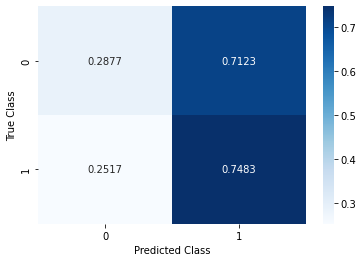

In [20]:
import seaborn as sns

cm = np.sum(best_cm, axis=0)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt=".4f", cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()